In [6]:
import numpy as np
import pandas as pd
from ProcessEntropy.CrossEntropy import get_all_lambdas

from collections.abc import Iterable

import matplotlib.pyplot as plt
import seaborn as sns

# need a function to flatten irregular list of lists
def flatten(xs):
    for x in xs:
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            yield from flatten(x)
        else:
            yield x

In [7]:
from numba import jit, prange

In [8]:
@jit(nopython=True, fastmath=True) 
def find_lambda_constrained_start(target, source):
    """
    Finds the longest subsequence of the target array, 
    starting from index 0, that is contained in the source array.
    Returns the length of that subsequence + 1.
    
    i.e. returns the length of the shortest subsequence starting at 0 
    that has not previously appeared.
    
    Args:
        target: NumPy array, preferable of type int.
        source: NumPy array, preferable of type int.
    
    Returns:
        Integer of the length.
        
    """
    source = np.array(source)
    target = np.array(target)
    
    source_size = source.shape[0]-1
    target_size = target.shape[0]-1
    t_max = 0
    c_max = 0

    
    if source[0] == target[0]:
        c_max = 1
        for ei in range(1,min(target_size+1, source_size +1)):
            if(source[ei] != target[ei]):
                break
            else:
                c_max = c_max+1

        if c_max > t_max:
            t_max = c_max 
                
    return t_max+1

In [63]:
N_events = 500
min_e_len = 1
max_e_len = 1
period = 5
source = [[np.random.randint(0,2) for j in range(np.random.randint(min_e_len,max_e_len+1))] for _ in range(N_events)]
target = [source[i-period] if np.random.rand()>0.5 else [np.random.randint(0,2) for j in range(np.random.randint(min_e_len,max_e_len+1))] for i in range(len(source))]
# time = np.arange(100)

# source = [(time[i],source[i]) for i in range(len(time))]
# target = [(time[i],target[i]) for i in range(len(time))]

relative_pos = np.array([i for i in range(1,len(source))], dtype = np.uint32)

target = list(flatten(target))
source = list(flatten(source))

In [154]:
N_events = 200
min_e_len = 1
max_e_len = 1
period = 20
V_size = 2


In [155]:
source = [[np.random.randint(0,V_size) for j in range(np.random.randint(min_e_len,max_e_len+1))] for _ in range(N_events+period)]
target = [source[i-period] if np.random.rand()>0.2 else [np.random.randint(0,V_size) for j in range(np.random.randint(min_e_len,max_e_len+1))] for i in range(len(source))]
target = target[period:]
source = source[period:]
target = list(flatten(target))
source = list(flatten(source))

In [158]:
i=30
n=20

find_lambda_constrained_start(target[i:], source[i-n:i])

2

In [215]:
N_events = 200
min_e_len = 1
max_e_len = 1
period = 20
V_size = 2
p=0.8 # prob we use item period steps ago

v = []
N_iter = 10
for iter in range(N_iter):
    # generate sequences
    source = [[np.random.randint(0,V_size) for j in range(np.random.randint(min_e_len,max_e_len+1))] for _ in range(N_events+period)]
    target = [source[i-period] if np.random.rand()>(1-p) else [np.random.randint(0,V_size) for j in range(np.random.randint(min_e_len,max_e_len+1))] for i in range(len(source))]
    # remove 'burn in'
    target = target[period:]
    source = source[period:]

    target = list(flatten(target))
    source = list(flatten(source))

    # starting index of target - only consider middle 1/3
    for i in range(len(target)//3,2*len(target)//3-1):
        for n in range(1,i): # length of history
            l = find_lambda_constrained_start(target[i:], source[i-n:i])
            e = np.log2(n) / l
            v.append([iter,i,n, l, e]) # relative position to lambda

    ## RELATIVE POS CAN"T CONTAIN VALUES LONGER THAN THE LENGTH


if j is the index and value in relative_pos, this gives the maximum length of the source for i> j

basically want to take lambda matched to min(i,j) - this gives the lambda for a given history lengthm

#### want to change it to \lambda / Log n

In [216]:
length_lambda_pairs = np.array(v)

In [220]:
df = pd.DataFrame({'iter':length_lambda_pairs[:,0].astype(int),
                   'i':length_lambda_pairs[:,1].astype(int),
                   'n':length_lambda_pairs[:,2].astype(int),
                   'Lambda':length_lambda_pairs[:,3].astype(int),
                   'Entropy':length_lambda_pairs[:,4]})

<Axes: xlabel='n', ylabel='Entropy'>

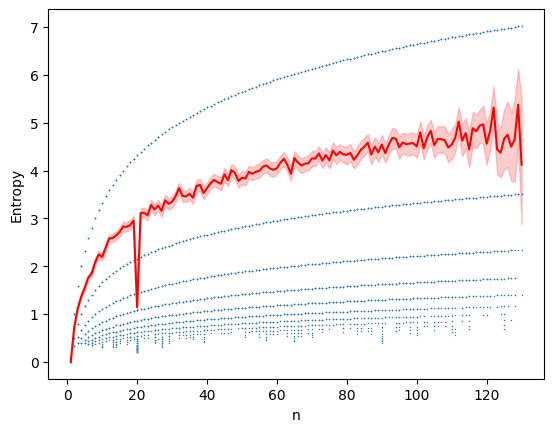

In [221]:
sns.scatterplot(data = df, x = 'n', y= 'Entropy',s=1)
sns.lineplot(data = df, x = 'n', y= 'Entropy', color='red')

<Axes: xlabel='Lambda', ylabel='Count'>

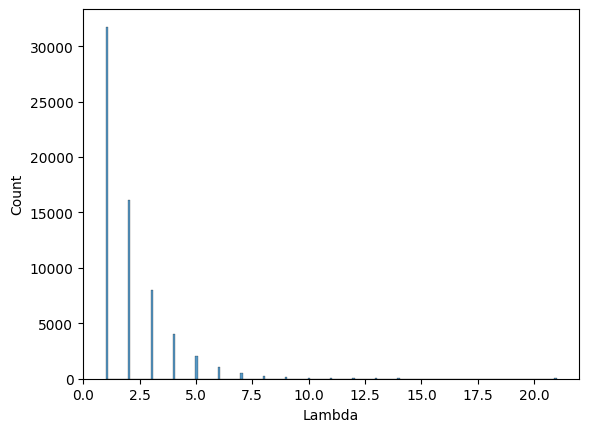

In [225]:
sns.histplot(data = df, x='Lambda')

In [224]:
np.mean(df.Lambda),np.max(df.Lambda),np.min(df.Lambda)

(2.066200466200466, 21, 1)

# now we want to get rid of when the history length constains the match length

<Axes: xlabel='n', ylabel='Entropy'>

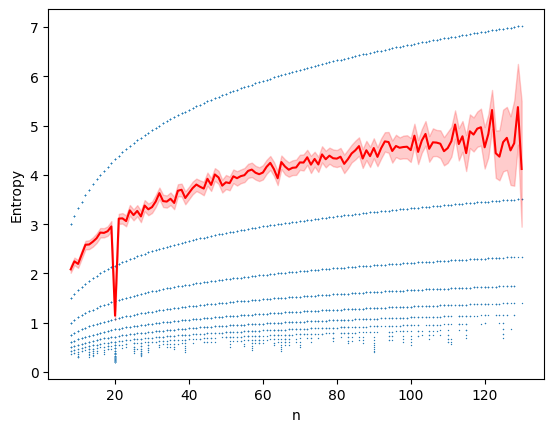

In [256]:
sns.scatterplot(data = df[df.n>7], x = 'n', y= 'Entropy',s=1)
sns.lineplot(data = df[df.n>7], x = 'n', y= 'Entropy', color='red')

<Axes: xlabel='n', ylabel='Lambda'>

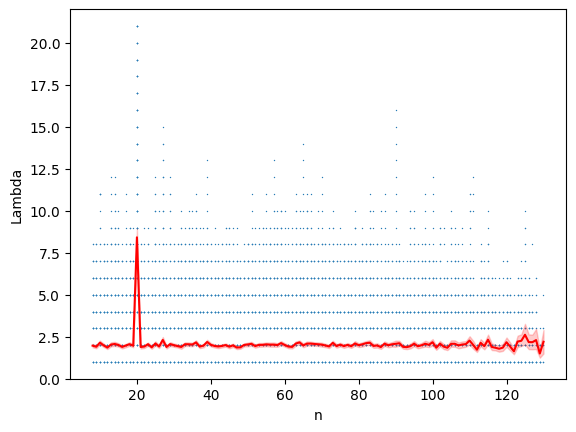

In [257]:
sns.scatterplot(data = df[df.n>7], x = 'n', y= 'Lambda',s=1)
sns.lineplot(data = df[df.n>7], x = 'n', y= 'Lambda', color='red')

In [255]:
df_filtered = df[df.n>7]

# now we want to isolate the unusual behaviour

In [219]:
df['predictability'] = np.log2(df['Entropy'].values)

/var/folders/xd/4fjxx_x91hx_4ffb41mw3vn80000gn/T/ipykernel_959/3495570747.py:1: RuntimeWarning: divide by zero encountered in log2
  df['predictability'] = np.log2(df['Entropy'].values)


<Axes: xlabel='n', ylabel='predictability'>

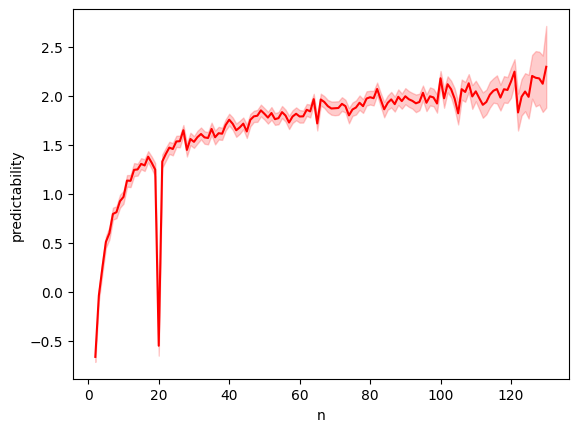

In [212]:
sns.lineplot(data = df, x = 'n', y= 'predictability', color='red')

In [258]:
df_filtered['Shuffled']=df_filtered.groupby('i').Lambda.apply(lambda x : x.sample(len(x))).values


/var/folders/xd/4fjxx_x91hx_4ffb41mw3vn80000gn/T/ipykernel_959/3254682620.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Shuffled']=df_filtered.groupby('i').Lambda.apply(lambda x : x.sample(len(x))).values


<Axes: xlabel='n', ylabel='Lambda'>

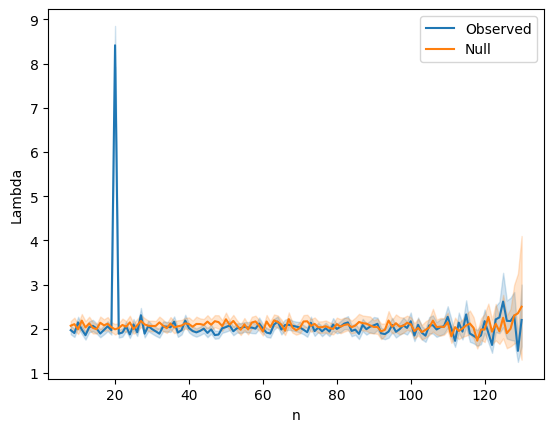

In [259]:
sns.lineplot(data = df_filtered, x = 'n', y= 'Lambda', label = 'Observed')
sns.lineplot(data = df_filtered, x = 'n', y= 'Shuffled', label = 'Null')

In [260]:
df_filtered['Diff'] = df_filtered.Lambda - df_filtered.Shuffled

/var/folders/xd/4fjxx_x91hx_4ffb41mw3vn80000gn/T/ipykernel_959/971115401.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Diff'] = df_filtered.Lambda - df_filtered.Shuffled


<Axes: xlabel='n', ylabel='Diff'>

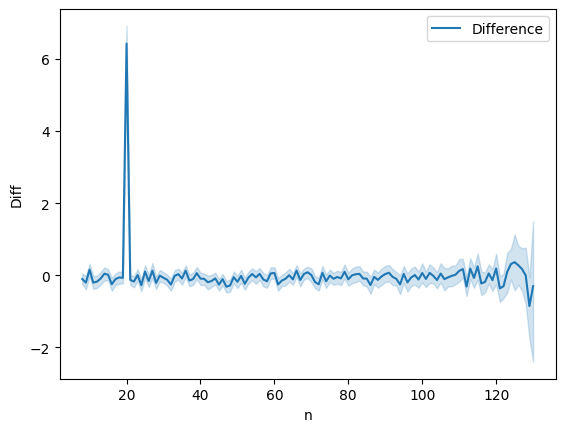

In [261]:
sns.lineplot(data = df_filtered, x = 'n', y= 'Diff', label = 'Difference')

# Overview

In [9]:
def period():
    return int(np.ceil(np.random.normal(5,1)))

<AxesSubplot:ylabel='Count'>

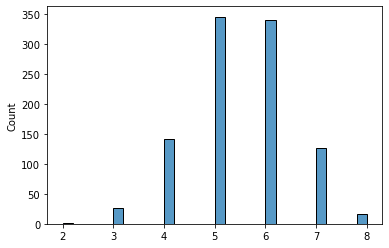

In [10]:
sns.histplot([np.ceil(np.random.normal(5,1)) for _ in range(1000)])

In [11]:
N_events = 100
min_e_len = 1
max_e_len = 1
p=0.8
mean = 5

v = []
N_iter = 20
for iter in range(N_iter):
    # generate sequences
    source = [[np.random.randint(0,2) for j in range(np.random.randint(min_e_len,max_e_len+1))] for _ in range(N_events)]
    target = [source[i-period()] if np.random.rand()>(1-p) else [np.random.randint(0,2) for j in range(np.random.randint(min_e_len,max_e_len+1))] for i in range(len(source))]

    # remove 'burn in'
    target = target[mean:]
    source = source[mean:]

    target = list(flatten(target))
    source = list(flatten(source))

    # starting index of target - only consider middle 1/3
    for i in range(len(target)//3,2*len(target)//3-1):
        for n in range(1,i): # length of history
            l = find_lambda_constrained_start(target[i:], source[i-n:i])
            e = np.log2(n) / l
            v.append([iter,i,n, l, e]) # relative position to lambda

    ## RELATIVE POS CAN"T CONTAIN VALUES LONGER THAN THE LENGTH


/var/folders/wp/758jq81s3hs0jlp8_31261sc0000gn/T/ipykernel_9824/1844435369.py:19: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'tmp0' of function 'jit_wrapper__built_in_function_array_'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<string>", line 2:
<source missing, REPL/exec in use?>

  source = np.array(source)
/opt/homebrew/Caskroom/miniforge/base/envs/hack/lib/python3.10/site-packages/numba/core/ir_utils.py:2152: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'source' of function 'find_lambda_constrained_start'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../../var/folders/wp/758

In [12]:
length_lambda_pairs = np.array(v) 
df = pd.DataFrame({'iter':length_lambda_pairs[:,0].astype(int),
                   'i':length_lambda_pairs[:,1].astype(int),
                   'n':length_lambda_pairs[:,2].astype(int),
                   'Lambda':length_lambda_pairs[:,3].astype(int),
                   'Entropy':length_lambda_pairs[:,4]})

In [13]:
df = df[df.n<N_events//2]

<AxesSubplot:xlabel='n', ylabel='Entropy'>

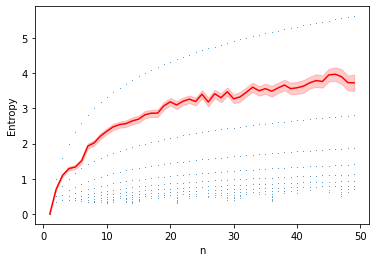

In [14]:
sns.scatterplot(data = df, x = 'n', y= 'Entropy',s=1)
sns.lineplot(data = df, x = 'n', y= 'Entropy', color='red')

<Axes: xlabel='n', ylabel='Entropy'>

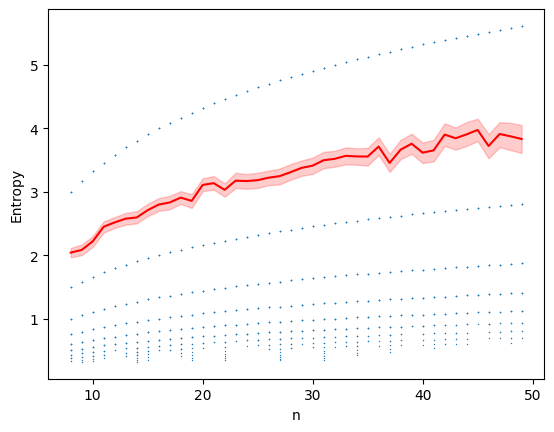

In [409]:
sns.scatterplot(data = df[df.n>7], x = 'n', y= 'Entropy',s=1)
sns.lineplot(data = df[df.n>7], x = 'n', y= 'Entropy', color='red')

In [410]:
df['Shuffled']=df.groupby('i').Lambda.apply(lambda x : x.sample(len(x))).values

<Axes: xlabel='n', ylabel='Lambda'>

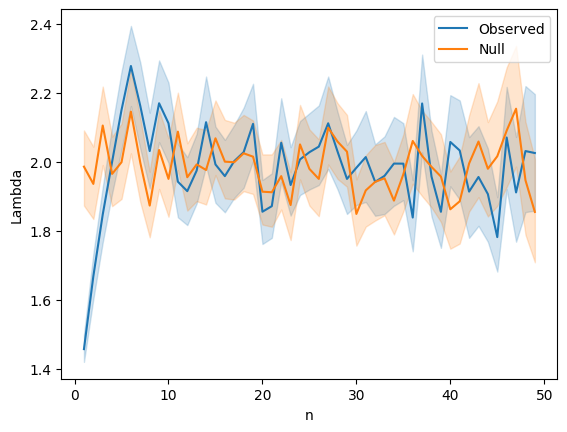

In [411]:
sns.lineplot(data = df, x = 'n', y= 'Lambda', label = 'Observed')
sns.lineplot(data = df, x = 'n', y= 'Shuffled', label = 'Null') 

<Axes: xlabel='n', ylabel='Diff'>

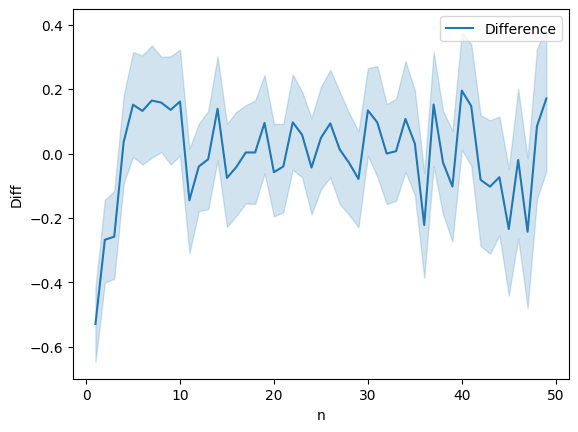

In [412]:
df['Diff'] = df.Lambda - df.Shuffled 
sns.lineplot(data = df, x = 'n', y= 'Diff', label = 'Difference')